In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

import os
import numpy as np
import pickle
import torch

from vis_utils.loaders import load_dataset
from vis_utils.plot import  plot_scatter
import sys
sys.path.append("..")
from scripts.utils import get_path

env: CUDA_VISIBLE_DEVICES=1


In [2]:
root_path = get_path("data")
fig_path = get_path("figures")

In [3]:
# parameters for all methods
dataset = "mnist"
k=15
seeds = [0, 1, 2]

n_epochs = 750
n_noise = 5
batch_size = 1024
lr_min_factor=0.0
clamp_low = 1e-10
anneal_lr = True


In [4]:
# set up matplotlib
plt.style.use("default")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
cmap = matplotlib.cm.get_cmap("tab10")
alpha = 0.3

In [5]:
# get data
x, y, sknn_graph, pca2 = load_dataset(root_path, dataset)

# Parametric

## adam annealing

In [6]:
parametric = True
optimizer = "adam"
loss_modes = ["neg_sample", "nce", "infonce"]

embedders_adam_anneal = []
for loss_mode in loss_modes:
    embedders_by_loss = []
    for s in seeds:
        file_name = os.path.join(root_path,
                                     dataset,
                                     f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_bs_{batch_size}"
                                     f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_param_{parametric}_clamp_low_{clamp_low}_seed_{s}.pkl"
                                     )
        with open(file_name, "rb") as file:
            embedder = pickle.load(file)
        embedders_by_loss.append(embedder)
    embedders_adam_anneal.append(embedders_by_loss)
    print(f"done with loss {loss_mode}")


done with loss neg_sample
done with loss nce
done with loss infonce


In [7]:
len(embedders_adam_anneal[0])

3

In [ ]:
# check out param embedding, esp different random seeds for neg_sample to see that cluster of ones is not always line

<AxesSubplot:>

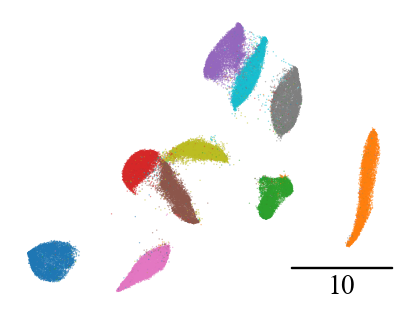

In [11]:
# save embeddings for seed 0
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), embedders_adam_anneal[0][0].callback.embds[-1][:, ::-1] @ np.array([[-1, 0], [0, 1]]), y)
#plt.savefig(os.path.join(fig_path,
#                         f"param_neg_mnist.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=200,
#            transparent=False,
#            facecolor='white')

<AxesSubplot:>

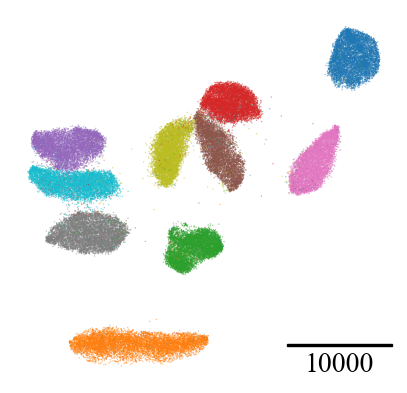

In [43]:
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), embedders_adam_anneal[1][0].callback.embds[-1] @ np.array([[0, -1], [-1, 0]]), y)
plt.savefig(os.path.join(fig_path,
                         f"param_nce_mnist.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

<AxesSubplot:>

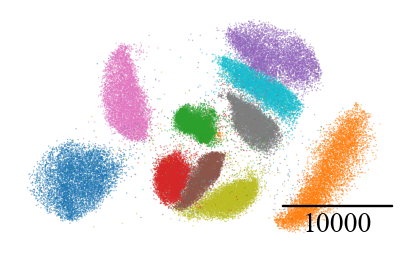

In [45]:
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), embedders_adam_anneal[2][0].callback.embds[-1] @ np.array([[1, 0], [0, -1]]), y)
plt.savefig(os.path.join(fig_path,
                         f"param_infonce_mnist.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

# non-parametric comparisons

In [8]:
parametric = False
optimizer = "sgd"
loss_modes = ["neg_sample", "nce", "infonce"]
rescale = 1.0
momentum=0.0


embedders_non_para_sgd = []
for loss_mode in loss_modes:
    embedders_by_loss = []
    for s in seeds:
        if loss_mode == "neg_sample":
            file_name = os.path.join(root_path,
                                         dataset,
                                         f"cne_{loss_mode}_n_noise_{n_noise}_noise_in_estimator_1.0_n_epochs_{n_epochs}_init_pca_rescale_{rescale}_bs_{batch_size}"
                                         f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{s}.pkl"
                                         )
        else:
            file_name = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_pca_rescale_{rescale}_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{s}.pkl"
                             )

        with open(file_name, "rb") as file:
            embedder = pickle.load(file)
        embedders_by_loss.append(embedder)
    embedders_non_para_sgd.append(embedders_by_loss)
    print(f"Done with loss {loss_mode}")

Done with loss neg_sample
Done with loss nce
Done with loss infonce


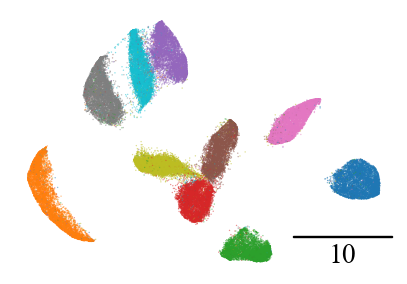

In [21]:
# save plots for seed 0
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), embedders_non_para_sgd[0][0].callback.embds[-1], y)
plt.savefig(os.path.join(fig_path,
                         f"neg_sample.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

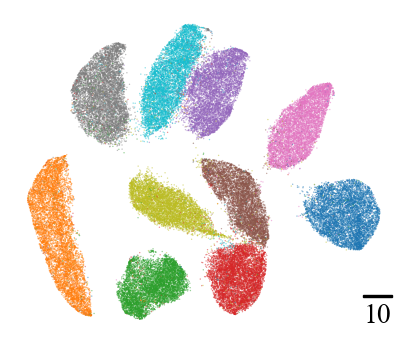

In [22]:
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), embedders_non_para_sgd[1][0].callback.embds[-1], y)
plt.savefig(os.path.join(fig_path,
                         f"nce_mnist.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

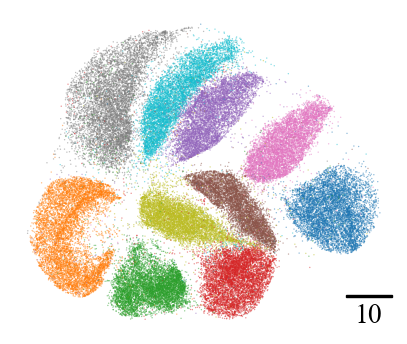

In [23]:
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), embedders_non_para_sgd[2][0].callback.embds[-1], y)
plt.savefig(os.path.join(fig_path,
                         f"infonce_mnist.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')

### Investigating scale difference ncvis and infonce

In [11]:
# compare scale

# rescale by noise distribution
Z_param = np.array([embedders_adam_anneal[1][i].callback.Zs for i in range(len(seeds))]) * len(x) * (len(x) -1)
Z_non_param = np.array([embedders_non_para_sgd[1][i].callback.Zs for i in range(len(seeds))]) * len(x) * (len(x) -1 )

norm_param = np.array([embedders_adam_anneal[1][i].callback.norms for i in range(len(seeds))])[:, :, 0]
norm_non_param = np.array([embedders_non_para_sgd[1][i].callback.norms for i in range(len(seeds))])[:, :, 0]

In [13]:

print(f"Final Z param NCE    : "+"{:.2e}".format(Z_param[-1].mean(0)))
print(f"Final Z non-param NCE: "+"{:.2e}".format(Z_non_param[-1].mean(0)))

print(f"Final partition function param NCE    : "+"{:.2e}".format(norm_param[-1].mean(0)))
print(f"Final partition function non-param NCE: "+"{:.2e}".format(norm_non_param[-1].mean(0)))
print(f"Final noralization value param NCE    : "+"{:.2e}".format((norm_param[-1] / Z_param[-1]).mean(0)))
print(f"Final noralization value non-param NCE: "+"{:.2e}".format((norm_non_param[-1] / Z_non_param[-1]).mean(0)))


Final Z param NCE    : 8.85e+06
Final Z non-param NCE: 5.81e+07
Final partition function param NCE    : 1.80e+06
Final partition function non-param NCE: 2.54e+07
Final noralization value param NCE    : 1.29e+00
Final noralization value non-param NCE: 4.38e-01


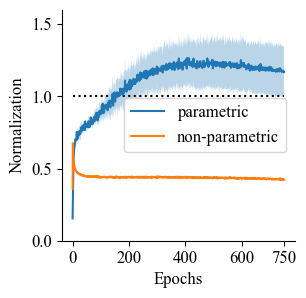

In [14]:
# plot normalization of model q / Z
plt.figure(figsize=(3,3))
fontsize = 12

plt.plot((norm_param / Z_param).mean(0), label="parametric")
plt.fill_between(np.arange(751),
                 (norm_param / Z_param).mean(0)- (norm_param / Z_param).std(0),
                 (norm_param / Z_param).mean(0)+ (norm_param / Z_param).std(0),
                 alpha = alpha)


plt.plot((norm_non_param / Z_non_param).mean(0), label="non-parametric")
plt.fill_between(np.arange(751),
                 (norm_non_param / Z_non_param).mean(0)- (norm_non_param / Z_non_param).std(0),
                 (norm_non_param / Z_non_param).mean(0)+ (norm_non_param / Z_non_param).std(0),
                 alpha = alpha)

plt.hlines(1, xmin=0, xmax=750, linestyles="dotted", colors="k")


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel("Epochs", fontsize=fontsize)
plt.ylabel("Normalization", fontsize=fontsize)

plt.xticks([0, 200, 400, 600, 750], fontsize=fontsize)
plt.yticks([0.0, 0.5, 1.0, 1.5], fontsize=fontsize)
plt.ylim(0.0, 1.6)

plt.legend(fontsize=fontsize)

plt.savefig(os.path.join(fig_path,
                         f"non_param_param_nce_norm.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

In [15]:
# plot losses
losses_ncvis_param = np.array([np.array(embedders_adam_anneal[1][i].losses).mean(-1) for i in range(len(seeds))])
losses_ncvis_no_param = np.array([np.array(embedders_non_para_sgd[1][i].losses).mean(-1) for i in range(len(seeds))])

losses_infonce_param = np.array([np.array(embedders_adam_anneal[2][i].losses).mean(-1) for i in range(len(seeds))])
losses_infonce_no_param = np.array([np.array(embedders_non_para_sgd[2][i].losses).mean(-1) for i in range(len(seeds))])

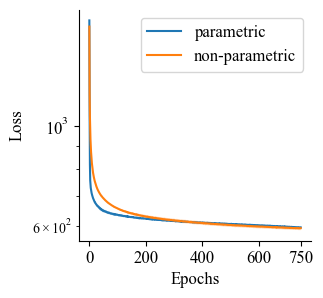

In [16]:
plt.figure(figsize=(3,3))
fontsize = 12

plt.plot(losses_ncvis_param.mean(0), label="parametric")
plt.fill_between(np.arange(750),
                 losses_ncvis_param.mean(0) - losses_ncvis_param.std(0),
                 losses_ncvis_param.mean(0) + losses_ncvis_param.std(0),
                 alpha = alpha)

plt.plot(losses_ncvis_no_param.mean(0), label="non-parametric")
plt.fill_between(np.arange(750),
                 losses_ncvis_no_param.mean(0) - losses_ncvis_no_param.std(0),
                 losses_ncvis_no_param.mean(0) + losses_ncvis_no_param.std(0),
                 alpha = alpha)


plt.yscale("log")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel("Epochs", fontsize=fontsize)
plt.ylabel("Loss", fontsize = fontsize)
plt.xticks([0, 200, 400, 600, 750], fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.legend(fontsize=fontsize)

plt.savefig(os.path.join(fig_path,
                         f"non_param_param_nce_loss.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

--> similar final loss values.

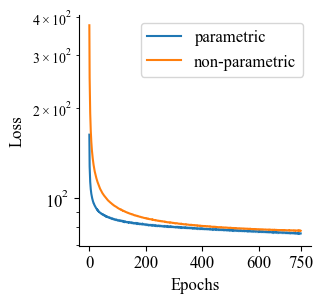

In [17]:
plt.figure(figsize=(3,3))
fontsize = 12


plt.plot(losses_infonce_param.mean(0), label="parametric")
plt.fill_between(np.arange(750),
                 losses_infonce_param.mean(0) - losses_infonce_param.std(0),
                 losses_infonce_param.mean(0) + losses_infonce_param.std(0),
                 alpha = alpha)

plt.plot(losses_infonce_no_param.mean(0), label="non-parametric")
plt.fill_between(np.arange(750),
                 losses_infonce_no_param.mean(0) - losses_infonce_no_param.std(0),
                 losses_infonce_no_param.mean(0) + losses_infonce_no_param.std(0),
                 alpha = alpha)

plt.yscale("log")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.legend(fontsize=fontsize)

plt.xlabel("Epochs", fontsize=fontsize)
plt.ylabel("Loss", fontsize=fontsize)

plt.xticks([0, 200, 400, 600, 750], fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.savefig(os.path.join(fig_path,
                         f"non_param_param_infonce_loss.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

--> similar loss values.

## investigating cluster of ones

In [12]:
mask1 = y == 1
embd1 = embedders_adam_anneal[0][0].callback.embds[-1][mask1]

In [13]:
embedders_adam_anneal[0][0].callback.embds[-1][mask1].shape

(7877, 2)

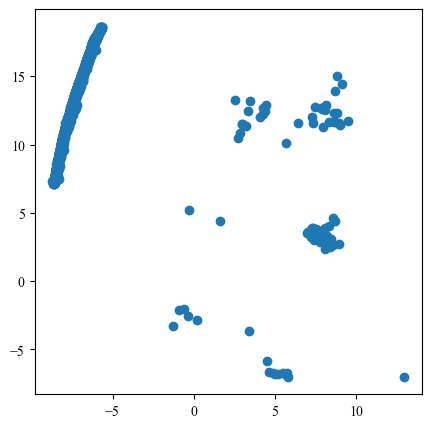

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(*embedders_adam_anneal[0][0].callback.embds[-1][mask1].T)
#plot_scatter(plt.gca(), embedders_adam_anneal[0][0].callback.embds[-1][mask1])

In [15]:
mask2 = embd1[:, 0]<-3
embd2 = embd1[mask2]

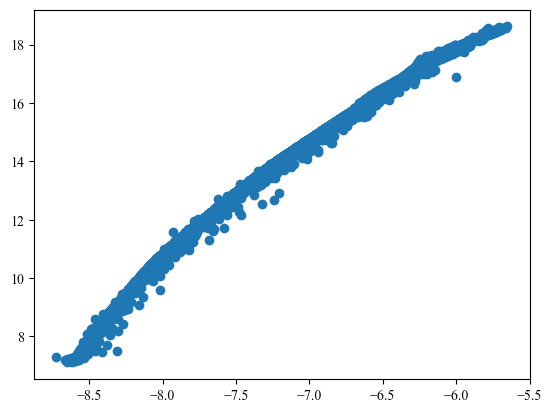

In [16]:
plt.scatter(*embd2.T)

In [17]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=1)
embd3 = pca1.fit_transform(embd2)
idx = np.argsort(embd3, axis=0)

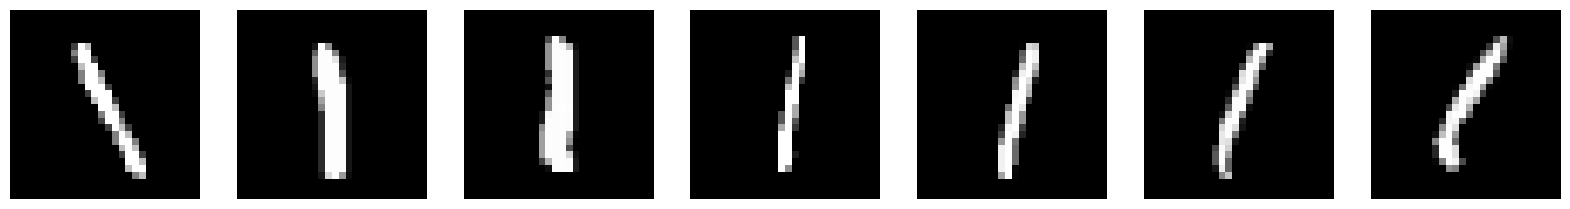

In [18]:
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(7):
    ax[i].imshow(x[mask1][mask2][idx[1000 * i]].reshape(28,28), cmap="gray")
    ax[i].axis("off")